In [16]:
import pandas as pd
import numpy as np
import json
from IPython.display import display
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import os
from datetime import timedelta
from sklearn.metrics import  accuracy_score,classification_report,roc_auc_score,log_loss,zero_one_loss,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM,CuDNNGRU,BatchNormalization, Input,Bidirectional,TimeDistributed,RepeatVector
from keras.layers.recurrent import LSTM
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping, Callback,ModelCheckpoint


#method used to evaluate our model
#returns a list of evaluation metrics
def classification_metric(y_true,y_predict):
    acc=accuracy_score(y_true,y_predict.round())
    roc_auc=roc_auc_score(y_true, y_predict.round())
    zero_one=zero_one_loss(y_true,y_predict.round())
    print('accuracy score',acc)
    print('roc_auc_score',roc_auc)
    print('log loss score',log_loss(y_true,y_predict))
    print('zero_one_loss score',zero_one)
    print('confusion_matrix',confusion_matrix(y_true,y_predict.round()))
    print(classification_report(y_true,y_predict.round()))
    
    return [roc_auc,zero_one,acc]
#method used to plot the values of churned data and non churned
def plot_churn_data(all_data,op,cp,bin_time):
    #data=X.copy()
    data=all_data.copy()
    data['churned']=y
    data=data.groupby(['churned']).mean()
    title='OP {} ,CP {} ,Bin {}'.format(op,cp,bin_time)
    data.T.plot(kind='line',title=title);
    
#method used to retrieve saved preprocessed data
#returns preprocessed dataframe
def get_preproc_data(include_team=False):
    
    if include_team:
        if os.path.isfile('processed_raw_data_with_team.p'):
            preprocessed_data=pickle.load(open('processed_raw_data_with_team.p', "rb" ))
    else:
        if os.path.isfile('processed_raw_data.p'):
            preprocessed_data=pickle.load(open('processed_raw_data.p', "rb" ))

    return preprocessed_data

#method used to only keep columns provided
#returns dataframe with filtered columns
def filter_columns(data,columns,to_filter=True):
    if to_filter:
        return data[columns]
    else:
        return data
    
#method used to scale data
#returns scaled data
def scale_numerical_data(data,scale=False):
    if scale: 
        #scaler=MinMaxScaler()
        scaler=StandardScaler()
        columns_to_encode=list(data.select_dtypes(include=['float64','int64']))

        features_transform = pd.DataFrame(data = data)
        features_transform[columns_to_encode] = scaler.fit_transform(data[columns_to_encode])
        return features_transform
    else:
        return data
#method used to get time series values based on the observation period,churn period and bin time for selected player
#returns row data
def player_reg_data(data,x,op,cp,bin_time):
        player_data=data.loc[data['player_name']==x]
        player_data.set_index('date',inplace=True)
        op_min_date=player_data.index.min()
        op_max_date=op_min_date+ pd.DateOffset(days=op)
        cp_max_date=op_max_date+ pd.DateOffset(days=cp)
        date_range=pd.date_range(start=op_min_date, end=op_max_date,freq=str(bin_time)+'T',closed=None)
        df2=pd.DataFrame({ 'player_score': 0 * len(date_range) },index=date_range )
        res_player_data=player_data.append(df2)
        res_player_data=res_player_data.resample(str(bin_time)+'T',label='right', closed=None).sum()
        res_player_data=res_player_data.loc[(res_player_data.index>=op_min_date)&(res_player_data.index<=op_max_date)]
        col_data=res_player_data['player_score'].tolist()
        cp_data=player_data.loc[(player_data.index > op_max_date) & (player_data.index<= cp_max_date)]
        col_data.append(1 if cp_data.empty else 0)
        return col_data
    
#used to generate our time series data for all players
#returns processed data
def gen_reg_data(op,cp,bin_time,include_team):
    #new_data=[]
    
    data=get_preproc_data(include_team)
    new_data=[player_reg_data(data,player,op,cp,bin_time) for player in tqdm(data['player_name'].unique())]
    #new_data.append(player_reg_data(data,player,op,cp,bin_time))
    reg_data=pd.DataFrame(new_data)
    return reg_data.rename(columns={ reg_data.columns[-1]: 'churned' })    

#used to retrieve saved data or call method to process data
#returns data or train,test data
def get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=False):
    
    name='reg_data_op_'+str(op)+'_'+str(cp)+'_bin_'+str(bin_time)+'.p'
    if os.path.isfile(name):
        data=pickle.load(open(name,'rb'))
    else:
        data=gen_reg_data(op,cp,bin_time,include_team)
        pickle.dump(data,open(name, "wb" ))

    if not as_data:
        y=data['churned']
        X=data.drop(['churned'],axis=1)
        X=scale_numerical_data(X,scale_data)
        X=X.values
        X=X.reshape((-1,X.shape[1], 1))
        return X,y
    else:
        return data
#method used to log and save results to file
def set_log_data(details,clf_metrics,save=True):
    details.extend(clf_metrics)
    
    if save:
        if os.path.isfile('log_data.csv'):
            df=pd.DataFrame([details])
            df.to_csv('log_data.csv', mode='a', header=False, index=False)
        else:
            column_names=['model','op','cp','bin_time','scaled','batch_size','epochs'
                     ,'with_team','kfold','roc_auc','zero_one_loss','accuracy']

            df=pd.DataFrame(data=[details],columns=column_names)
            df.to_csv('log_data.csv', header=True, index=False)
def read_log_data():
    if os.path.isfile('log_data.csv'):
        return pd.read_csv('log_data.csv')
    else:
        return None
#simple rrn model
#returns model
def rnn_model(layers):
    model = Sequential()
    #input shape follows the (sequence length,time)
    #input shape (Sequence length(50),num of features(1)), neurons=(seq len)50
    model.add(CuDNNLSTM( input_shape=(layers[1], layers[0]), units=128))
    
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=[
                                                                "binary_accuracy"])
    return model
#bidirectional gru model
#returns model
def bidir_model(layers):
    inp_seq=Input(shape=(layers[1], layers[0]))
    rnn=Bidirectional(CuDNNGRU(256,return_sequences=True),merge_mode='concat')(inp_seq)
    drp_out = Dropout(0.2)(rnn)
    bidir_rnn = Bidirectional(CuDNNGRU(256))(drp_out)
    drp_out = Dropout(0.2)(bidir_rnn)
    logits=Dense(1)(drp_out)
    logits=Activation("sigmoid")(logits)
    
    #cost=Activation('softmax')(logits)
    model=Model(inp_seq,logits)
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=[
                                                                "binary_accuracy"])
    return model

#bidirectional batch norm model
#returns model
def bi_rnn_norm_model(layers):
    inp_seq=Input(shape=(layers[1], layers[0]))
    rnn=Bidirectional(CuDNNGRU(256,return_sequences=True),merge_mode='concat')(inp_seq)
    drp_out = Dropout(0.2)(rnn)
    bidir_rnn = Bidirectional(CuDNNGRU(256))(drp_out)
    drp_out = Dropout(0.2)(bidir_rnn)
    hid_dense=Dense(10)(drp_out)
    drp_out = BatchNormalization()(hid_dense)
    logits=Dense(1)(drp_out)
    logits=Activation("sigmoid")(logits)
    
    model=Model(inp_seq,logits)
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=[ "binary_accuracy", 'sparse_categorical_accuracy' ])
    return model
#gru batch norml model
def rnn_norm_dense_model(layers):
    inp_seq=Input(shape=(layers[1], layers[0]))
    rnn=CuDNNGRU(256,return_sequences=True)(inp_seq)
    drp_out = Dropout(0.2)(rnn)
    rnn=CuDNNGRU(256,return_sequences=True)(drp_out)
    drp_out = Dropout(0.2)(rnn)
    bidir_rnn = CuDNNGRU(256)(drp_out)
    drp_out = Dropout(0.2)(bidir_rnn)
    hid_dense=Dense(10)(drp_out)
    drp_out = BatchNormalization()(hid_dense)
    logits=Dense(1)(drp_out)
    logits=Activation("sigmoid")(logits)
    
    #cost=Activation('softmax')(logits)
    model=Model(inp_seq,logits)
    model.compile(loss="binary_crossentropy", optimizer='adam',metrics=[ "binary_accuracy", 'sparse_categorical_accuracy' ])
    return model

def bi_rnn_norm_dense_model(layers):
    inp_seq=Input(shape=(layers[1], layers[0]))
    rnn=Bidirectional(CuDNNGRU(256,return_sequences=True),merge_mode='concat')(inp_seq)
    drp_out = Dropout(0.2)(rnn)
    bidir_rnn = Bidirectional(CuDNNGRU(256))(drp_out)
    drp_out = Dropout(0.2)(bidir_rnn)
    hid_dense=Dense(10)(drp_out)
    drp_out = Dropout(0.2)(hid_dense)
    logits=Dense(1)(drp_out)
    logits=Activation("sigmoid")(logits)
    
    #cost=Activation('softmax')(logits)
    model=Model(inp_seq,logits)
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=[
                                                                "binary_accuracy"])
    return model

def rnn_norm_2_dense_model(layers):
    inp_seq=Input(shape=(layers[1], layers[0]))
    rnn=CuDNNGRU(128,return_sequences=True)(inp_seq)
    drp_out = Dropout(0.2)(rnn)
    bidir_rnn = CuDNNGRU(256)(drp_out)
    drp_out = Dropout(0.2)(bidir_rnn)
    hid_dense=Dense(10)(drp_out)
    drp_out = Dropout(0.2)(hid_dense)
    hid_dense=Dense(10)(drp_out)
    drp_out = BatchNormalization()(hid_dense)
    logits=Dense(1)(drp_out)
    logits=Activation("sigmoid")(logits)
    
    #cost=Activation('softmax')(logits)
    model=Model(inp_seq,logits)
    model.compile(loss="binary_crossentropy", optimizer='adam',metrics=[ "binary_accuracy", 'sparse_categorical_accuracy' ])
    return model    
#file used to fit and predict the provided model
#logs data to file
def fit_predict_model(model,model_name,X_train,y_train,X_test,y_test,op=7,cp=14,bin_time=30,batch_size=256,epochs=25,num_kfold=0,
                      with_team=False,scaled=False,save=True):
    name='{}_op{}_cp{}_bin{}_sc{}_bch{}_ep{}_tm{}_kf{}.h5'.format(model_name,op,cp,bin_time,scaled,batch_size,epochs,with_team,num_kfold)
    if os.path.isfile(name):
        model.load_weights(name)
        pred=model.predict(X_test)
        clf_metrics=classification_metric(y_test,pred)
    else:
        model.fit(X_train,y_train,batch_size=batch_size,shuffle=True,epochs=epochs,validation_split=0.20,verbose=0)
        model.save_weights(name)
        pred=model.predict(X_test)
        clf_metrics=classification_metric(y_test,pred)
        details=[model_name,op,cp,bin_time,scaled,batch_size,epochs,with_team,num_kfold]
        set_log_data(details,clf_metrics,save)
#gets the mean of our validation metric for kfold
#returns the mean of our metrics
def get_metric_results(list_metrics):
    df_metric=pd.DataFrame(list_metrics)
    print(df_metric.mean())
    return df_metric.mean()
#method used to build a kfold model
def build_model_kfold(model,model_name,X,y,op,cp,bin_time,batch_size,epochs,total_folds,scaled,save):
    

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)
    
    X_test=X_test.values.reshape((-1,X_test.shape[1], 1))
    
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=42)
    fold_num = 0
    
    # drivers are split into train and validation sets
    list_metrics=[]
    for train, test in kf.split(X_train):
            print(train.shape)
            train_x,train_y=X_train.iloc[train],y_train.iloc[train]
            val_x,val_y=X_train.iloc[test],y_train.iloc[test]
            print(train_x.shape,val_x.shape)
            
            train_x=train_x.values
            train_x=train_x.reshape((-1,X.shape[1], 1))
            
            val_x=val_x.values
            val_x=val_x.reshape((-1,X.shape[1], 1))
            
            fold_num+=1
            kfold_weights_path='{}_numfold{}_op{}_cp{}_bin{}_sc{}_bch{}_ep{}_tm{}_kf{}.h5'.format(model_name,fold_num,op,cp,bin_time,
                                                             scaled,batch_size,epochs,False,total_folds)
            if not os.path.isfile(kfold_weights_path) :
                callbacks = [
                        EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=0),
                        ModelCheckpoint(kfold_weights_path, monitor='val_binary_accuracy', save_best_only=True, verbose=2)
                            ]
                model.fit(train_x,train_y,batch_size=batch_size,shuffle=True,epochs=epochs,
                          validation_data=(val_x,val_y),verbose=0,callbacks=callbacks)                
                                
            if os.path.isfile(kfold_weights_path):
                model.load_weights(kfold_weights_path)   
                
            pred=model.predict(X_test)
            
            clf_metrics=classification_metric(y_test,pred)
            list_metrics.append(clf_metrics)
    details=[model_name,op,cp,bin_time,scaled,batch_size,epochs,False,total_folds]
    avg_score=get_metric_results(list_metrics)
    set_log_data(details,avg_score,save)

In [17]:
read_log_data()

,model,op,cp,bin_time,scaled,batch_size,epochs,with_team,kfold,roc_auc,zero_one_loss,accuracy
0,bi_rnn_norm_model,5,10,30,False,256,25,False,0,0.722265,0.228298,0.771702
1,bidir_model,5,10,30,False,256,25,False,0,0.729867,0.224880,0.775120
2,rnn_norm_dense_model,5,10,30,False,256,25,False,0,0.721211,0.228640,0.771360
3,rnn_model,5,10,30,False,256,25,False,0,0.730014,0.224197,0.775803
4,bi_rnn_norm_dense_model,5,10,30,False,256,25,False,0,0.718562,0.230007,0.769993
5,rnn_norm_2_dense_model,5,10,30,False,256,25,False,0,0.724890,0.225222,0.774778
6,bi_rnn_norm_model,4,7,30,False,256,25,False,0,0.712512,0.238209,0.761791
7,bidir_model,4,7,30,False,256,25,False,0,0.712033,0.241627,0.758373
8,rnn_norm_dense_model,4,7,30,False,256,25,False,0,0.724281,0.249487,0.750513
9,bi_rnn_norm_model,4,4,30,False,256,25,False,0,0.728580,0.214627,0.785373


## Immediate Churners

In [18]:
random_state=42
op=4
cp=7
bin_time=30
batch_size=256
epochs=25
num_kfold=0
save=True

scale_data=False
#default
include_team=False
X,y=get_reg_data(op,cp,bin_time,include_team,scale_data)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)

In [19]:
model = rnn_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'rnn_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,num_kfold,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________
accuracy score 0.754272043745728
roc_auc_score 0.7162451955592947
log loss score 0.5359686334984745
zero_one_loss score 0.24572795625427202
confusion_matrix [[ 618  471]
 [ 248 1589]]
             precision    recall  f1-score   support

          0       0.71      0.57      0.63      1089
          1       0.77      0.86      0.82      1837

avg / total       0.75      0.75      0.75      2926



In [20]:
model = bi_rnn_norm_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'bi_rnn_norm_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,
                  num_kfold,include_team,scale_data,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 192, 1)            0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 192, 512)          397824    
_________________________________________________________________
dropout_12 (Dropout)         (None, 192, 512)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 512)               1182720   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10)                40        
__________

In [21]:
model = rnn_norm_dense_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'rnn_norm_dense_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,num_kfold,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 192, 1)            0         
_________________________________________________________________
cu_dnngru_14 (CuDNNGRU)      (None, 192, 256)          198912    
_________________________________________________________________
dropout_14 (Dropout)         (None, 192, 256)          0         
_________________________________________________________________
cu_dnngru_15 (CuDNNGRU)      (None, 192, 256)          394752    
_________________________________________________________________
dropout_15 (Dropout)         (None, 192, 256)          0         
_________________________________________________________________
cu_dnngru_16 (CuDNNGRU)      (None, 256)               394752    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
__________

In [188]:
batch_size=256
epochs=50
num_kfold=10
save=True
scale_data=False
data=get_reg_data(op,cp,bin_time,include_team,scale_data,True)
y=data['churned']
X=data.drop(['churned'],axis=1)
X=scale_numerical_data(X,scale_data)

model = rnn_norm_dense_model([1, X.shape[1]])
model.summary()
build_model_kfold(model,'rnn_norm_dense_model',X,y,op,cp,bin_time,batch_size,epochs,num_kfold,scale_data,save=save)

(10532,)
(10532, 192) (1171, 192)
accuracy score 0.7573479152426521
roc_auc_score 0.7175731182263572
log loss score 0.5326432703726213
zero_one_loss score 0.2426520847573479
confusion_matrix [[ 612  477]
 [ 233 1604]]
             precision    recall  f1-score   support

          0       0.72      0.56      0.63      1089
          1       0.77      0.87      0.82      1837

avg / total       0.75      0.76      0.75      2926

(10532,)
(10532, 192) (1171, 192)
accuracy score 0.7576896787423103
roc_auc_score 0.7199017942077278
log loss score 0.5302754567543927
zero_one_loss score 0.2423103212576897
confusion_matrix [[ 623  466]
 [ 243 1594]]
             precision    recall  f1-score   support

          0       0.72      0.57      0.64      1089
          1       0.77      0.87      0.82      1837

avg / total       0.75      0.76      0.75      2926

(10532,)
(10532, 192) (1171, 192)
accuracy score 0.758714969241285
roc_auc_score 0.7216531125077669
log loss score 0.5312414752206143


## Gradual Churners

In [22]:
random_state=42
op=15
cp=15
bin_time=30
batch_size=256
epochs=25
num_kfold=0
save=True

scale_data=False
#default
include_team=False
X,y=get_reg_data(op,cp,bin_time,include_team,scale_data)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)

In [23]:
model = rnn_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'rnn_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,num_kfold,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________
accuracy score 0.9077238550922762
roc_auc_score 0.846892669316807
log loss score 0.23037450583250613
zero_one_loss score 0.09227614490772384
confusion_matrix [[ 306   95]
 [ 175 2350]]
             precision    recall  f1-score   support

          0       0.64      0.76      0.69       401
          1       0.96      0.93      0.95      2525

avg / total       0.92      0.91      0.91      2926



In [24]:
model = bi_rnn_norm_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'bi_rnn_norm_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,
                  num_kfold,include_team,scale_data,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 720, 1)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 720, 512)          397824    
_________________________________________________________________
dropout_17 (Dropout)         (None, 720, 512)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 512)               1182720   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
_________________________________________________________________
batch_normalization_8 (Batch (None, 10)                40        
__________

In [25]:
model = rnn_norm_dense_model([1, X.shape[1]])
model.summary()
fit_predict_model(model,'rnn_norm_dense_model',X_train,y_train,X_test,y_test,op,cp,bin_time,batch_size,epochs,num_kfold,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 720, 1)            0         
_________________________________________________________________
cu_dnngru_19 (CuDNNGRU)      (None, 720, 256)          198912    
_________________________________________________________________
dropout_19 (Dropout)         (None, 720, 256)          0         
_________________________________________________________________
cu_dnngru_20 (CuDNNGRU)      (None, 720, 256)          394752    
_________________________________________________________________
dropout_20 (Dropout)         (None, 720, 256)          0         
_________________________________________________________________
cu_dnngru_21 (CuDNNGRU)      (None, 256)               394752    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
__________

In [26]:
batch_size=256
epochs=50
num_kfold=10
save=True
scale_data=False
data=get_reg_data(op,cp,bin_time,include_team,scale_data,True)
y=data['churned']
X=data.drop(['churned'],axis=1)
X=scale_numerical_data(X,scale_data)

model = bi_rnn_norm_model([1, X.shape[1]])
model.summary()
build_model_kfold(model,'bi_rnn_norm_model',X,y,op,cp,bin_time,batch_size,epochs,num_kfold,scale_data,save=save)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 720, 1)            0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 720, 512)          397824    
_________________________________________________________________
dropout_22 (Dropout)         (None, 720, 512)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 512)               1182720   
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
_________________________________________________________________
batch_normalization_10 (Batc (None, 10)                40        
__________

## Parameter selection

In [ ]:
op=3
cp=7
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

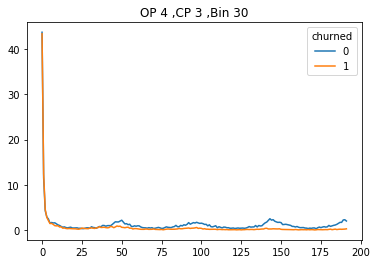

In [87]:
op=4
cp=3
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

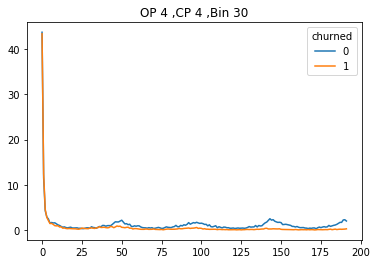

In [88]:
op=4
cp=4
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

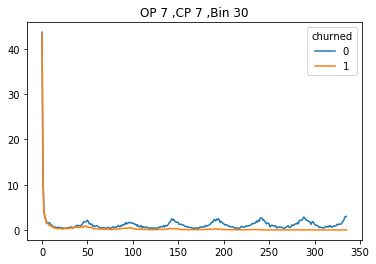

In [89]:
op=7
cp=7
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

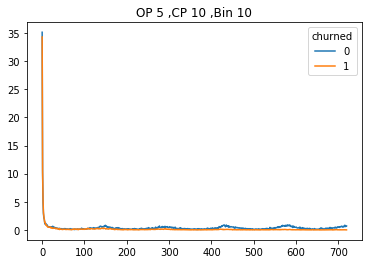

In [85]:
op=5
cp=10
bin_time=10
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

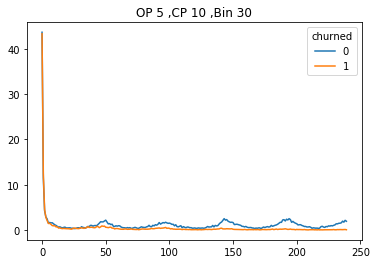

In [86]:
#OP CP selection
op=5
cp=10
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

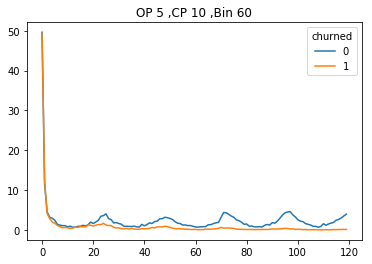

In [90]:
op=5
cp=10
bin_time=60
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

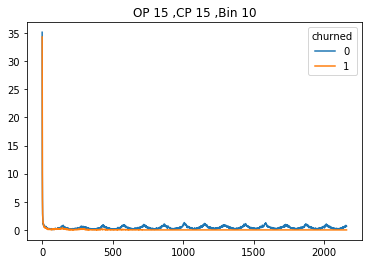

In [91]:
op=15
cp=15
bin_time=10
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

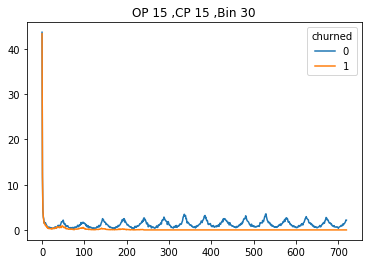

In [92]:
op=15
cp=15
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

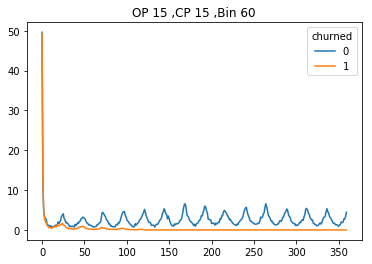

In [93]:
op=15
cp=15
bin_time=60
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

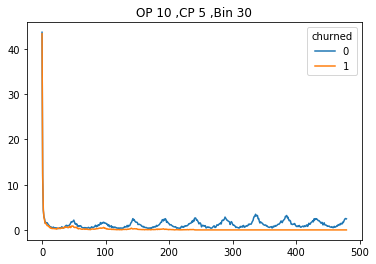

In [79]:
op=10
cp=5
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

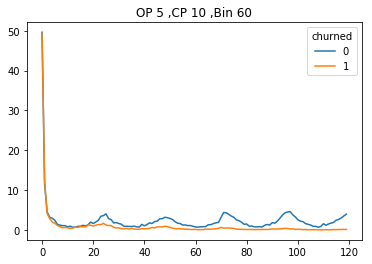

In [80]:
op=5
cp=10
bin_time=60
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

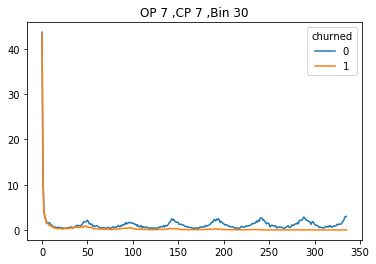

In [81]:
op=7
cp=7
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)

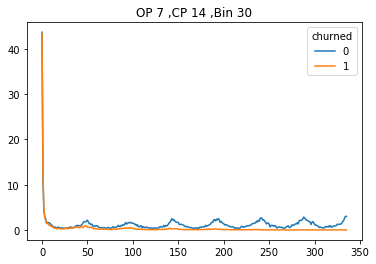

In [82]:
op=7
cp=14
bin_time=30
data=get_reg_data(op,cp,bin_time,include_team,scale_data,as_data=True)
plot_churn_data(data,op,cp,bin_time)